# Create new utility function

Import data.

In [1]:
%load_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
print('load data')
path = '../../dgym-data'

deck = dg.MoleculeCollection.from_sdf(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

load data


In [2]:
building_blocks = dg.datasets.enamine(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630.fpb')

# align fingerprints to building blocks
print('align fingerprints')
fingerprints = dg.utils.sort_fingerprints(fingerprints, building_blocks)

# partition building blocks according to functional groups
print('partition building blocks')
templates = dg.utils.get_unique_reactants(reactions)
building_blocks = dg.utils.partition_building_blocks(building_blocks, templates, out_dir=path)

align fingerprints
partition building blocks


Create inputs to the DrugEnv.

In [323]:
import numpy as np
from dgym.envs.library_designer import LibraryDesigner
from dgym.envs.oracle import DGLOracle, RDKitOracle
from dgym.envs.evaluator import ClassicEvaluator, UtilityFunction

# create library designer
library_designer = LibraryDesigner(
    reactions,
    building_blocks,
    fingerprints
)

# create assays
log_P_oracle = RDKitOracle('MolLogP')
log_S_oracle = DGLOracle('GCN_canonical_ESOL')
assays = [log_S_oracle, log_P_oracle]

# create evaluators
# ideal = (-2, 0)
log_S_evaluator = ClassicEvaluator(ideal=(-1, 0), acceptable=(-4, 0.5))
# ideal = (1, 4)
log_P_evaluator = ClassicEvaluator(ideal=(1, 3), acceptable=(0, 5))

# create utility function
utility_function = UtilityFunction(
    evaluators = [log_S_evaluator, log_P_evaluator],
    strategy = lambda x: np.prod(x)
)

First, set up the environment.

In [333]:
from dgym.envs.drug_env import DrugEnv
from dgym.agents import HardcodedDrugAgent
from tqdm import tqdm_notebook as tqdm

budgets = [0, 5, 20, 50, 100, 200, 500, 1_000, 5_000, 10_000]
results = []
for i in tqdm(range(20)):
    drug_env = DrugEnv(
        library_designer,
        library = deck[[42]],
        assays = assays,
        budget = budgets[i],
        utility_function=utility_function,
    )

    drug_agent = HardcodedDrugAgent(
        action_space=drug_env.action_space,
        scoring_functions=assays,
        utility_function=utility_function,
        epsilon=0.33,
        fraction_random=0.2,
        num_analogs=1,
        branch_factor=5
    )
    
    observations, info = drug_env.reset()

    while True:
        action = drug_agent.act(observations)
        observations, reward, terminated, truncated, info = drug_env.step(action)

        print(round_, '\t', reward)
        # print(action)
        if terminated:
            print('terminated!')
            break
        if truncated:
            print('truncated!')
            break

        # import seaborn as sns
        # sns.displot(drug_agent.policy(drug_env.library))

0 	 0.6207067290842531
1 	 0.8262561957041423
2 	 0.8262561957041423
3 	 1
terminated!


Draw lineage of best molecule.

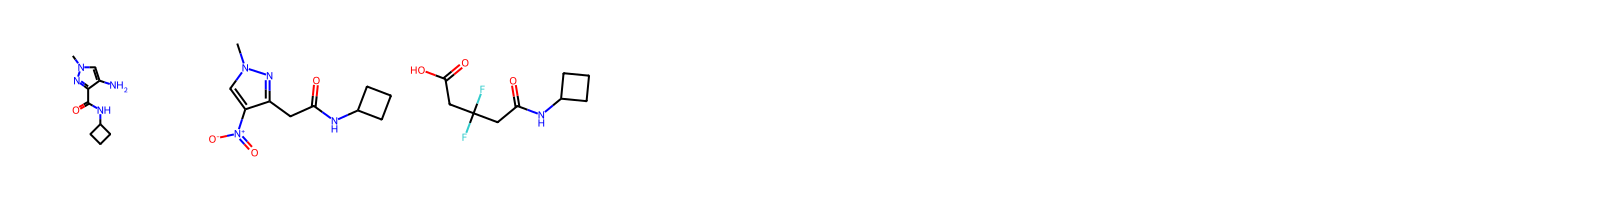

0.6207067290842531		0.6106847879787286		1


(-1.2017120122909546, 0.2845999999999995)

(-2.2398717403411865, 0.5394999999999999)

(-0.9800273180007935, 1.1551999999999998)

In [339]:
from rdkit.Chem import Draw

utility = drug_agent.policy(observations)
index = int(np.argsort(utility)[-1])

mol = drug_env.library[index]
lineage = [mol]
while mol.inspiration:
    mol = mol.inspiration
    lineage.insert(0, mol)

assay_results = [assay(lineage) for assay in assays]
results = [
    utility_function.score(properties)
    for properties in zip(*assay_results)
]

display(Draw.MolsToGridImage(
    [m.mol for m in lineage],
    molsPerRow=8,
    maxMols=10_000
))

print('\t\t'.join(map(str, results)))
display(*zip(*assay_results))